# Linear regression example

In [3]:
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import time

In [4]:
#Get data from csv file
data = pd.read_csv("LinearExample/insurance.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
#Explore data
print ("Rows     : " , data.shape[0])
print ("Columns  : " , data.shape[1])
print ("\nFeatures : \n", data.columns.tolist())
print ("\nMissing values :  ", data.isnull().sum().values.sum())
print ("\nUnique values :  \n", data.nunique())

Rows     :  1338
Columns  :  7

Features : 
 ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Missing values :   0

Unique values :  
 age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Check bmi distribution

In [8]:
dataNp = data.to_numpy()

age = dataNp[:, 0]
age = age.astype('float64')
sex = dataNp[:, 1]
bmi = dataNp[:,2]
bmi = bmi.astype('float64')
children = dataNp[:, 3]
smoker = dataNp[:, 4]
region = dataNp[:, 5]
charges = dataNp[:, 6]
charges = charges.astype('float64')

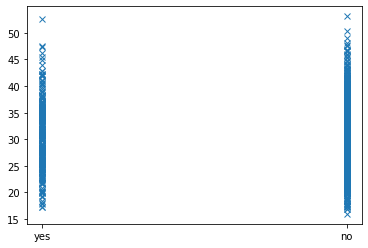

In [9]:
#plt.hist(charges, bins=15)
#plt.show()
plt.plot(smoker, bmi, 'x');

### Check charges distribution

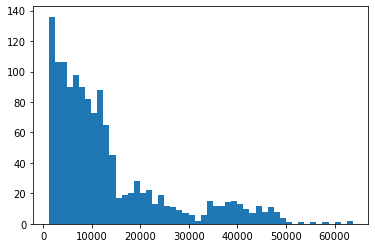

In [10]:
plt.hist(charges, bins=50)
plt.show()

Charges distribution has 3 clusters, most of the cases fall in the range 0 - 10000 aprox

### Checking relationship between age and charges

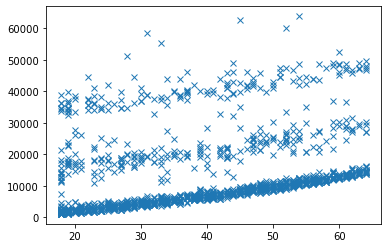

In [11]:
plt.plot(age, charges, 'x');

Checking plot, seems that there is a linear relation between these variables. It's very spreaded though.

Let's try to find a linear equation that fits this data just for fun.

With this visualization, 3 clusters are visible.
How do they relate with other variables?
How can I find the relation between a cluster and another variable(s)?

### Training the model to predict charges uisng age

In [12]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Normalize data

In [13]:
#Get normalize values before spliting sets
ageNorm = np.linalg.norm(age)
chargesNorm = np.linalg.norm(charges)

#divide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(age, charges, train_size=0.65,test_size=0.35)

#Get data sample sizes
trainDataSize = X_train.size
testDataSize = y_test.size

#normalize data
X_train =  X_train / ageNorm
X_test =  X_test / ageNorm
y_train = y_train / chargesNorm
y_test = y_test / chargesNorm

### Plot after normalization

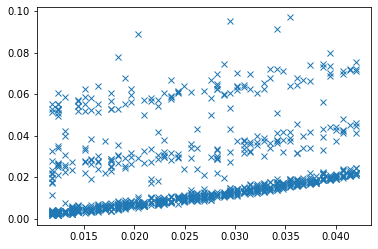

In [14]:
plt.plot(X_train, y_train, 'x');

### Use sklearn to train model and then plot calculated function and train data together

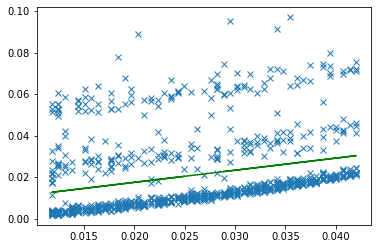

B0: [0.00574152], B1: [0.58467172]


In [15]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

slbeta0 = linr.intercept_
slbeta1 = linr.coef_[0]

yplot = X_train * slbeta1 + slbeta0

plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot, 'g')
plt.show()

print(f'B0: {slbeta0}, B1: {slbeta1}')

### Evaluate model with coeficients provided by sklearn, Plot error distribution

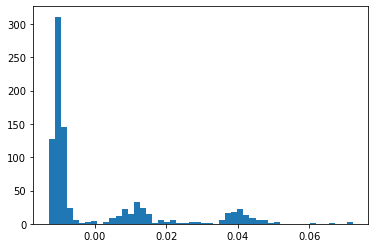

In [16]:
slyhat = X_train * slbeta1 + slbeta0
error = y_train - slyhat

plt.hist(error, bins=50)
plt.show()

Error distribution shows 3 kernels, leftmost (negative) shows where most of the data is present.

### Use pytorch to train model

In [17]:
n_epochs = 100
#batch_size_train = round(trainDataSize / 2)
batch_size_train = trainDataSize
batch_size_test = testDataSize
learning_rate = 0.01
momentum = 0.9
log_interval = 10

# transform to torch tensor
tensor_train_x = torch.Tensor(X_train.reshape(-1, 1))
tensor_train_y = torch.Tensor(y_train.reshape(-1, 1))

# create your datset
train_data = TensorDataset(tensor_train_x, tensor_train_y)

#Create loader using data
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True)

# transform to torch tensor
tensor_test_x = torch.Tensor(X_test.reshape(-1, 1))
tensor_test_y = torch.Tensor(y_test.reshape(-1, 1))

# create your datset
test_data = TensorDataset(tensor_test_x, tensor_test_y)

#Create loader using data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test,
    shuffle=True)

In [18]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)
    
#Network model
network = LayerLinearRegression()

#Configure loss function
LossFunction = nn.MSELoss(reduction='mean')

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [19]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [20]:
def train(epoch):
  #Configure network for training
  network.train()

  for batch_idx, (data, target) in enumerate(train_loader):
       
    #set parameters gradients to 0
    optimizer.zero_grad()
    
    #runs model with data and returns result in output
    output = network(data)
    
    #Calculate loss.
    loss = LossFunction(output, target)
    
    #Gradients are calculated
    loss.backward()
    
    #update gradients
    optimizer.step()
    
    #Display iteration statistics
    #if batch_idx % log_interval == 0:
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    train_losses.append(loss.item())
    train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))

In [21]:
def test():
    #Sets the module in evaluation mode
    network.eval()
    test_loss = 0
    correct = 0
    
    #dont update dynamic computation graph
    with torch.no_grad():
        #for every example in test
        for data, target in test_loader:
            #evaluate the model
            output = network(data)
            #acumulate the loss
            test_loss += LossFunction(output, target).item()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('\nTest set: Avg. loss: {:.6f}\n'.format(test_loss))

In [22]:
#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")


Test set: Avg. loss: 0.001094

Train Epoch: 1 	Loss: 0.510774

Test set: Avg. loss: 0.001051

Train Epoch: 2 	Loss: 0.490547

Test set: Avg. loss: 0.000972

Train Epoch: 3 	Loss: 0.453628

Test set: Avg. loss: 0.000866

Train Epoch: 4 	Loss: 0.404326

Test set: Avg. loss: 0.000744

Train Epoch: 5 	Loss: 0.347234

Test set: Avg. loss: 0.000615

Train Epoch: 6 	Loss: 0.286811

Test set: Avg. loss: 0.000487

Train Epoch: 7 	Loss: 0.227053

Test set: Avg. loss: 0.000368

Train Epoch: 8 	Loss: 0.171270

Test set: Avg. loss: 0.000262

Train Epoch: 9 	Loss: 0.121949

Test set: Avg. loss: 0.000174

Train Epoch: 10 	Loss: 0.080714

Test set: Avg. loss: 0.000105

Train Epoch: 11 	Loss: 0.048356

Test set: Avg. loss: 0.000054

Train Epoch: 12 	Loss: 0.024924

Test set: Avg. loss: 0.000022

Train Epoch: 13 	Loss: 0.009854

Test set: Avg. loss: 0.000005

Train Epoch: 14 	Loss: 0.002120

Test set: Avg. loss: 0.000001

Train Epoch: 15 	Loss: 0.000393

Test set: Avg. loss: 0.000006

Train Epoch: 16 	

### Plot training result with pytorch

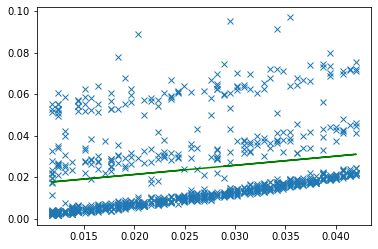

B0: [0.01239151], B1: [[0.44207612]]


In [23]:
beta1, beta0 = network.parameters()

beta0 = beta0.data.numpy()
beta1 = beta1.data.numpy()

yplot = X_train * beta1 + beta0
plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot.reshape(-1, 1), 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

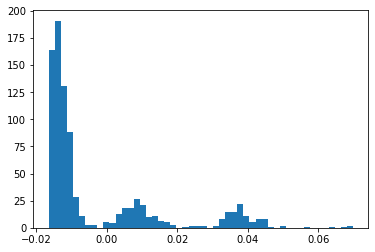

In [24]:
with torch.no_grad():
    yhat = X_train * beta1 + beta0
    error = y_train - yhat

    plt.hist(error.reshape(-1, 1), bins=50)
    plt.show()

### Plot test loss curve

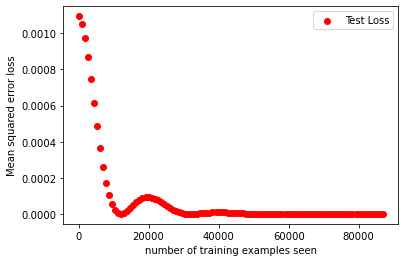

In [25]:
#fig = plt.figure()
#plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Mean squared error loss')
plt.show()

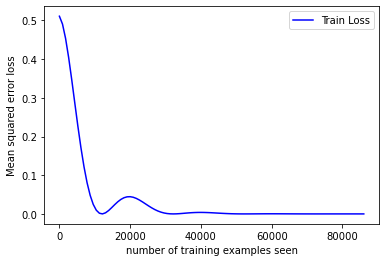

In [26]:
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Mean squared error loss')
plt.show()

### Result analysis

As shown below, model gets stuck with a local minimum resulting in a predicted line which doesn't fit very well the data. Why sklearn always gets a good result?
This are te configuration used,
epochs = 400
batch size = sample / 4
learning_rate = 0.01
momentum = 0.9

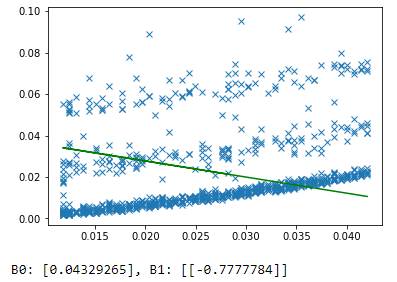

n_epochs = 400
batch_size_train = round(trainDataSize / 2)
batch_size_test = testDataSize
learning_rate = 0.01
momentum = 0.9
log_interval = 10

Error plot from example below, result in a distribution very different from the optimum result

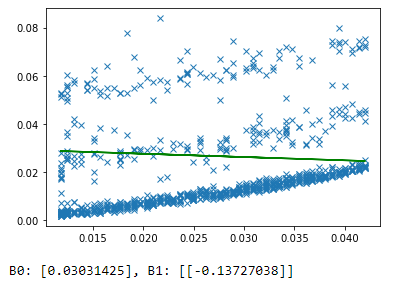

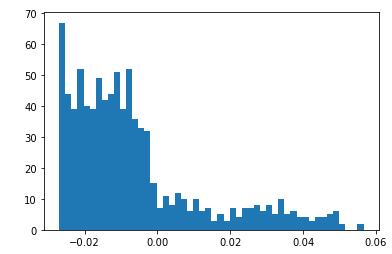

As shown below. data has a cluster with a large number of data, very close eachother with a linear shape, and two less dense more disperse clusters. In the error distribution we can see first a thin but high distribution corresponding to the first cluster, and two more disperse after.

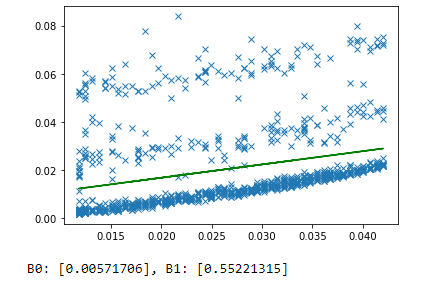

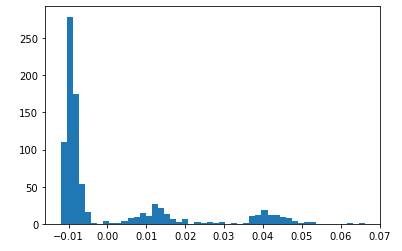

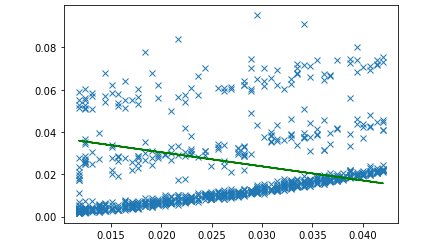

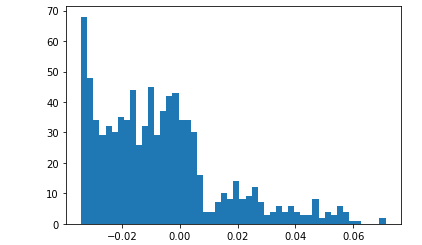

In [32]:
#Check charges in obese and smokers
data[(data['bmi'] > 30) & (data['smoker'] == 'yes')].describe()

,age,bmi,children,charges
count,144.000000,144.000000,144.000000,144.000000
mean,39.104167,35.544757,1.104167,41692.808992
std,14.361331,4.184624,1.113922,5829.158699
min,18.000000,30.020000,0.000000,32548.340500
25%,25.750000,32.275000,0.000000,37243.904350
50%,37.500000,34.960000,1.000000,40918.314500
75%,51.000000,37.207500,2.000000,45704.068725
max,64.000000,52.580000,4.000000,63770.428010


In [31]:
#Check charges in obese and smokers
data[(data['bmi'] < 30) & (data['smoker'] == 'no')].describe()

,age,bmi,children,charges
count,502.000000,502.000000,502.000000,502.00000
mean,37.960159,25.555548,1.069721,7977.02952
std,13.575486,3.145819,1.227236,5839.22811
min,18.000000,15.960000,0.000000,1121.87390
25%,26.000000,23.465000,0.000000,3733.58500
50%,37.000000,26.030000,1.000000,6761.61525
75%,49.000000,28.087500,2.000000,10905.68660
max,64.000000,29.925000,5.000000,35160.13457


<AxesSubplot:>

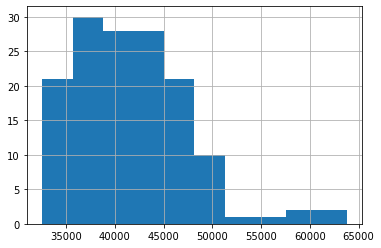

In [33]:
#Check charges in obese and smokers
data[(data['bmi'] > 30) & (data['smoker'] == 'yes')]['charges'].hist()

<AxesSubplot:>

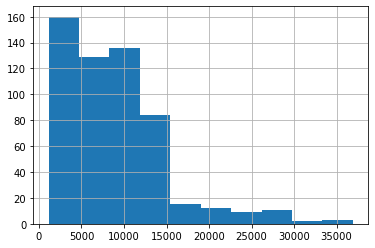

In [34]:
#Check charges in obese and smokers
data[(data['bmi'] > 30) & (data['smoker'] == 'no')]['charges'].hist()

# References

- https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
- https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
- Data was taken from: https://www.kaggle.com/mirichoi0218/insurance
- https://www.kaggle.com/yogidsba/insurance-claims-eda-hypothesis-testing

# ToDo

- Sometimes model is not converging, how can I fix this?
- Check other parameters to tune in the model to improve model converging.
- When data is very spread, what is the best approach to get a better result?
- Analize other characteristic from data to check how to better predict charges
- Check how data is saved in train_counter
- Check relation with smoker and charges
- Check the following implementations
- https://www.kaggle.com/sudhirnl7/linear-regression-tutorial
- https://www.kaggle.com/janiobachmann/patient-charges-clustering-and-regression
- https://www.kaggle.com/hely333/eda-regression
- It seems that there is a big impact in charges when person is obese
Under Weight: Body Mass Index (BMI)  <  18.5
Normal Weight: Body Mass Index (BMI)  ≥  18.5 and Body Mass Index (BMI)  <  24.9
Overweight: Body Mass Index (BMI)  ≥  25 and Body Mass Index (BMI)  <  29.9
Obese: Body Mass Index (BMI)  >  30
- Since no smokers are charged very similar, but being obese and being smoker takes more impact, perhaps create a new field taking into account somokers, and obese.

# Notes

- Since data is very spread, using an small batch size the model doesn't seems to converge, if I use a bigger batch size, it does better.
- What is the difference between a model and nn.Linear? nn.Module is a neural network containers. Linear is a type of layer